In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(15, 6))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv("train.csv", parse_dates=["date"])
print(data)
data = data.set_index("date").to_period('D')
data

             date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [3]:
def store_item_selector(df, store_num, item_num):
    df= df[(df['store']==store_num) & (df['item']==item_num)]
    return df

In [4]:
store = int(input("Input the required store number: "))
item = int(input("Input the required item number: "))
# # print(store)
# store = 1
# item = 5

Input the required store number: 5
Input the required item number: 9


            store  item  sales
date                          
2013-01-01      5     9     21
2013-01-02      5     9     20
2013-01-03      5     9     15
2013-01-04      5     9     20
2013-01-05      5     9     23
...           ...   ...    ...
2017-12-27      5     9     30
2017-12-28      5     9     24
2017-12-29      5     9     33
2017-12-30      5     9     50
2017-12-31      5     9     45

[1826 rows x 3 columns]


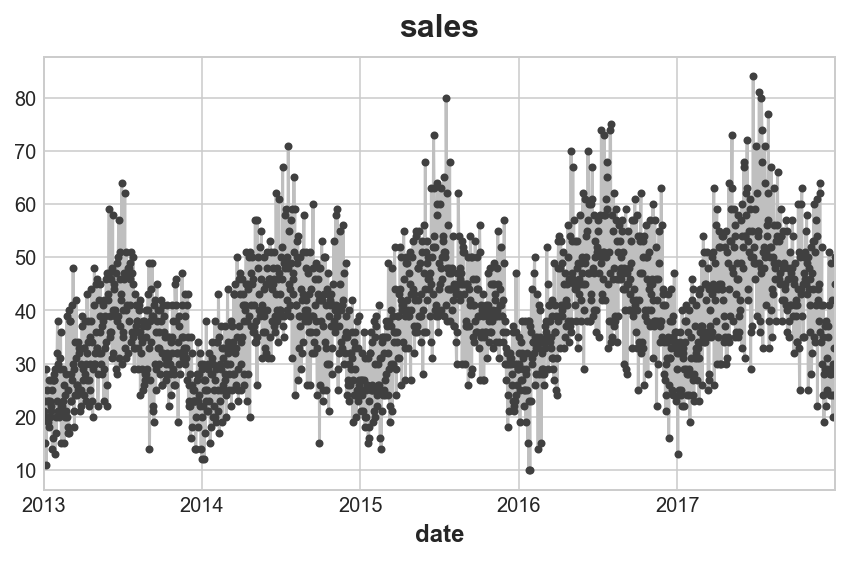

In [5]:
sales_data = store_item_selector(data, store_num = store, item_num = item)
print(sales_data)

# sns.lineplot(x= sales_data.index, y= sales_data['sales'])
ax = sales_data["sales"].plot(title = 'sales', **plot_params)

            const   trend
date                     
2013-01-01    1.0     1.0
2013-01-02    1.0     2.0
2013-01-03    1.0     3.0
2013-01-04    1.0     4.0
2013-01-05    1.0     5.0
...           ...     ...
2017-12-27    1.0  1822.0
2017-12-28    1.0  1823.0
2017-12-29    1.0  1824.0
2017-12-30    1.0  1825.0
2017-12-31    1.0  1826.0

[1826 rows x 2 columns]


C:\Users\win10\AppData\Local\Temp\ipykernel_7680\3604788128.py:33: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
C:\Users\win10\AppData\Local\Temp\ipykernel_7680\3604788128.py:34: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
C:\Users\win10\AppData\Local\Temp\ipykernel_7680\3604788128.py:35: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


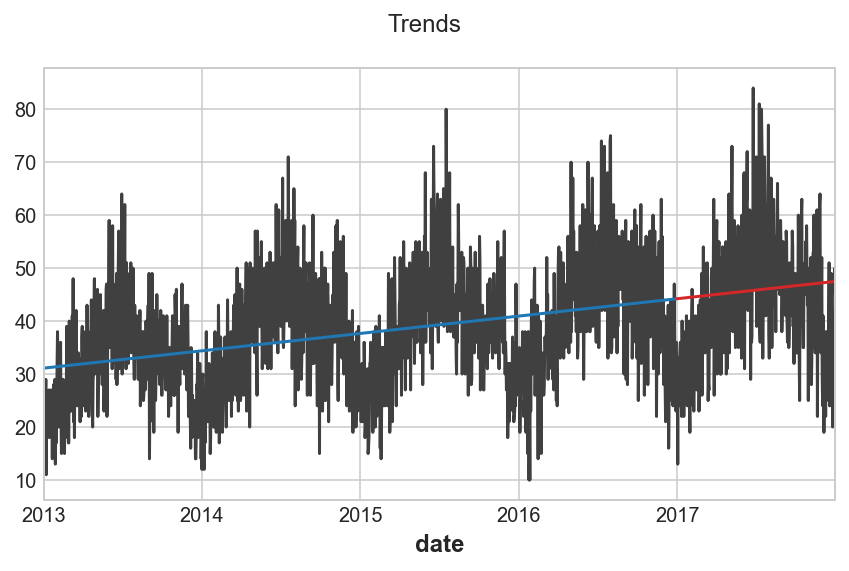

In [19]:
y = pd.DataFrame(sales_data.sales.copy())

dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order =1,
    drop = True,
)
X = dp.in_sample()
print(X)

idx_train, idx_test = train_test_split(
    y.index , test_size = 0.2, shuffle = False,
)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(
    model.predict(X_train),
    index = y_train.index,
    columns = y_train.columns
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index = y_test.index,
    columns = y_test.columns
)
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


In [42]:
from sklearn.tree import DecisionTreeRegressor
y_resid = y_train - y_fit
x = sales_data.copy().drop(['sales', 'store', 'item'], axis = 1)
# x = sales_data.stack()
x["Month"] = x.index.month
x["Weeks"]= x.index.week
x['day_of_week'] = x.index.dayofweek
# s = x.pop('sales')
print(x)

x_train, x_test = x.loc[idx_train, :], x.loc[idx_test, :]

xgb= DecisionTreeRegressor()
xgb.fit(x_train, y_resid)


y_fit_boosted = xgb.predict(x_train) + pd.Series(y_fit['sales'])

y_pred_boosted = xgb.predict(x_test) + pd.Series(y_pred['sales'])



            Month  Weeks  day_of_week
date                                 
2013-01-01      1      1            1
2013-01-02      1      1            2
2013-01-03      1      1            3
2013-01-04      1      1            4
2013-01-05      1      1            5
...           ...    ...          ...
2017-12-27     12     52            2
2017-12-28     12     52            3
2017-12-29     12     52            4
2017-12-30     12     52            5
2017-12-31     12     52            6

[1826 rows x 3 columns]


C:\Users\win10\AppData\Local\Temp\ipykernel_7680\2432955256.py:2: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs,)
C:\Users\win10\AppData\Local\Temp\ipykernel_7680\2432955256.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.plot(
C:\Users\win10\AppData\Local\Temp\ipykernel_7680\2432955256.py:6: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.plot(


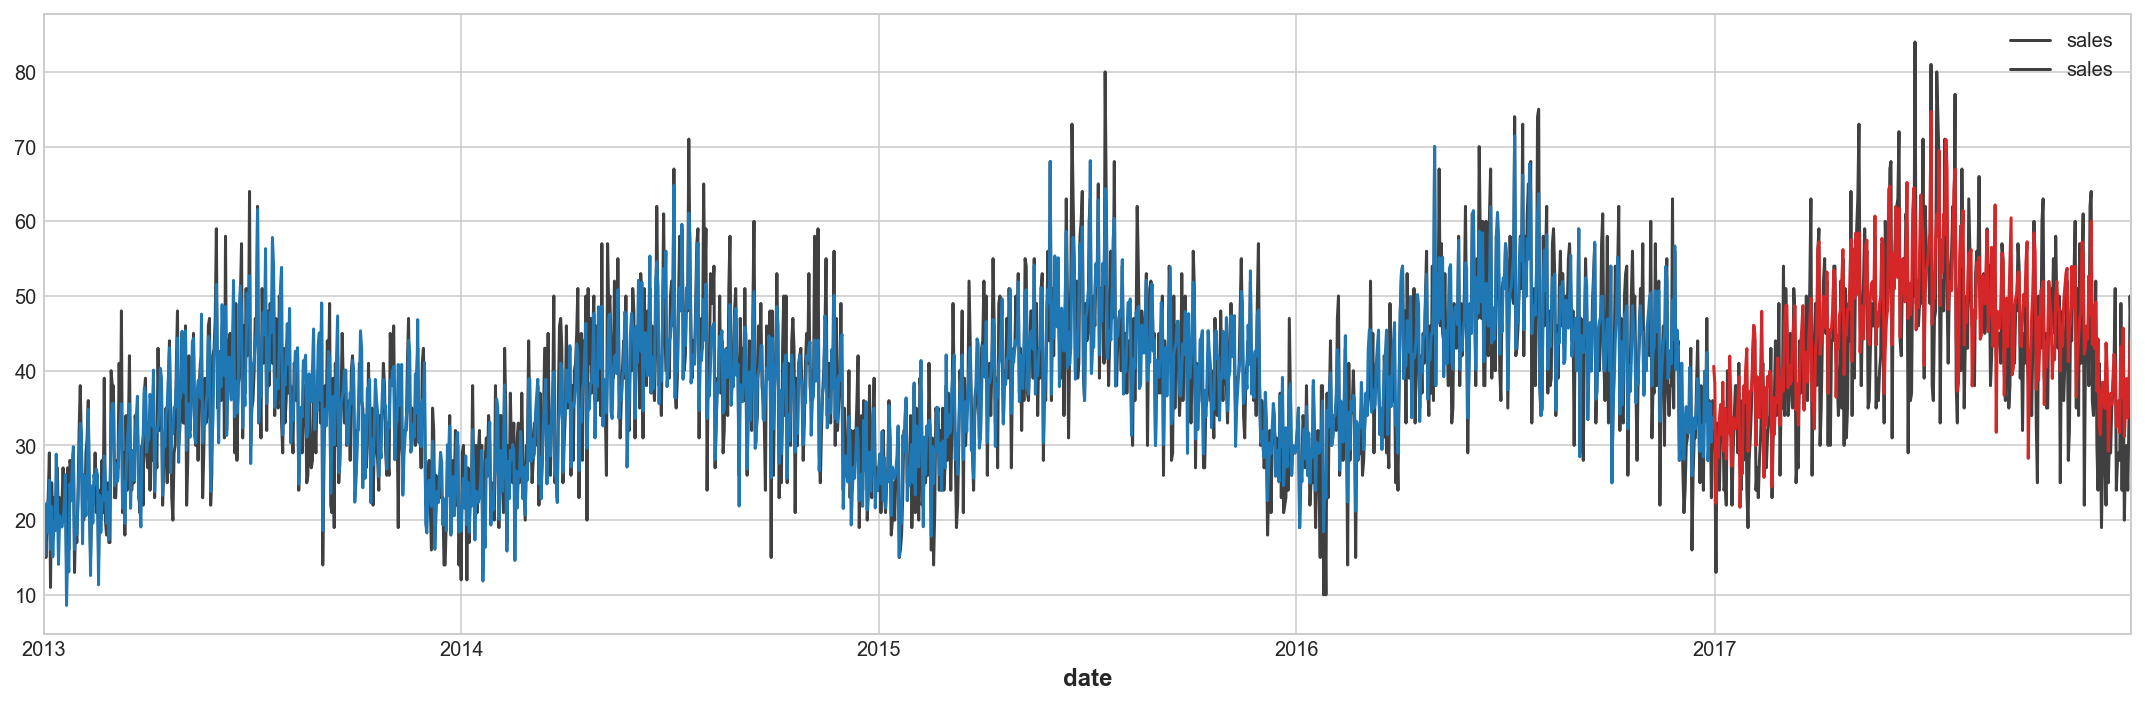

In [43]:
axs = y_train.plot(color='0.25', figsize=(15, 5), subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs,)
axs = y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)

In [44]:
# # def store_wise_sales(df):
# print(data)
# df = data.copy()
# print(df.head())
# store_wise_df = pd.DataFrame()
# for i in range(0, (df['store'][-1]+1)):
#     store_data = df[ df['store']==i ]
#     print(store_data)

In [45]:
from sklearn.metrics import mean_absolute_error 
mAe= mean_absolute_error(y_pred_boosted, y_test)


In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y_test, y_pred_boosted))
rms

8.139995398662661

In [47]:
ratio = rms/y_test.mean()
ratio

sales    0.186985
dtype: float64

sales    0.18548
dtype: float64